In [75]:
#Uses debiased sinkhorn method to compare random PAIRS of images
#to visualize and determine robustness to noise

import math
import matplotlib.pyplot as plt
import numpy as np
import torch
import ot
import os
import warnings
import sys
import sinkhorn_barycenters as sink
from itertools import combinations

#set variables
n = 3 #choosing n pairs (noise, no noise) of random datasets
epsilon = 1e-1 #will optimize this later
max_iterations = 30000 #will optimize this later
width = 50
rng = np.random.RandomState(42)#42


In [66]:
#function to choose n random artificial datasets
def find_index(n):
    index = rng.choice(np.arange(200), size=(n), replace=False)
    index.sort()
    return index

#returing variables
index = find_index(n)


In [67]:
print(index)

[15 30 95]


In [68]:
#load datasets, this function takes the random indexes and loads n pairs of artificial data with and without noise
def load_data(num_pairs, index):
    noise = []
    nonoise = []
    for i in range(len(index)):
        noise.append(abs(np.load("./artificial_data.npy")[index[i], :, :]))
        nonoise.append(np.load("./artificial_data_no_noise.npy")[index[i], :, :])
    return np.asarray(noise), np.asarray(nonoise)
        

#returning variables
noise, nonoise = load_data(n,index) 


In [69]:
#formatting function
def debiased_format(dataset, epsilon):
    P = torch.from_numpy(dataset)    
    grid = torch.arange(width).type(torch.float64)
    grid /= width
    M = (grid[:, None] - grid[None, :]) ** 2
    K = torch.exp(- M / epsilon)
    #K = torch.from_numpy(K)
    return P, K

#creating variables for debiased algo
P_nonoise, K_nonoise = debiased_format(nonoise, epsilon)
P_noise, K_noise = debiased_format(noise, epsilon)

print(P_nonoise.shape)
print(K_nonoise.shape)

torch.Size([3, 50, 50])
torch.Size([50, 50])


In [72]:
##Runs every combination of pairs for data sets within noise and no noise respectively

def run_sinkhorn(n, index, max_iterations, P_noise, K_noise, P_nonoise, K_nonoise):
    #row_num = int((n*(n-1))/2)
    q_nonoise = []
    q_noise = []
    index_list = []
    for i in range(len(index)):
        index_list.append(i)
    #list of all unique combinations of pairs of indices of datasets    
    combo_list = list(combinations(index_list,2)) 

    for i in range(len(combo_list)):
        first_set = combo_list[i][0]
        second_set = combo_list[i][1]
        #number for the image corresponding to the dataset
        image_nums = [index[first_set],index[second_set]] 
        #getting indices for all possible combinations of pairs
        ind = torch.tensor([first_set, second_set])
        #all possible combinations of pairs of images with no noise
        Pnonoise = torch.index_select(P_nonoise, 0, ind)
        qnonoise = sink.barycenter(Pnonoise, K_nonoise, reference="debiased", maxiter = max_iterations)
        q_nonoise.append(qnonoise)

        #all possible combinations of pairs of images with noise
        Pnoise = torch.index_select(P_noise, 0, ind)
        qnoise = sink.barycenter(Pnoise, K_noise, reference="debiased", maxiter = max_iterations)
        q_noise.append(qnoise)
        
    return combo_list, image_nums, q_nonoise, q_noise

#combo_list, image_nums, q_nonoise, q_noise = run_sinkhorn(n, index, max_iterations, P_noise, K_noise, P_nonoise, K_nonoise)        




In [74]:
max_iterations = [1e6] 
epsilon = [5e-3, 1e-1, .2, .3, .7] 
parameters = []    
qno = []
qyes = []
combo_list = []
image_nums = []
           



for m in max_iterations:
    for e in epsilon:
        m = int(m)
        e = float(e)
        parameters.append([m,e])
        P_nonoise, K_nonoise = debiased_format(nonoise, e)
        P_noise, K_noise = debiased_format(noise, e)
        combo_list, image_nums, q_nonoise, q_noise = run_sinkhorn(n, index, m, P_noise, K_noise, P_nonoise, K_nonoise)        
        qno.append(q_nonoise)
        qyes.append(q_noise)
        #tracking indices here
        combo_list.append(combo_list)
        image_nums.append(image_nums)
        
        


KeyboardInterrupt: 

In [7]:
np.save("./qnonoise_barycenters3.npy", qno)
np.save("./qwithnoise_barycenters3.npy", qyes)           
np.save("./parameters_barycenters3.npy", parameters)

NameError: name 'qno' is not defined

In [62]:
#function to plot just the barycenters
def plot_compare(q_noise, q_nonoise):
    m=1
    for i in range(0,len(q_nonoise)): 
        plt.figure(1, figsize=(10,100))
        plt.subplot(len(q_nonoise),2,i+m)
        plt.imshow(q_nonoise[i][0]) 
        plt.title(f"No Noise \n max iterations: {int(parameters[i][0])} and epsilon: {parameters[i][1]}")
        plt.axis("off")

        plt.subplot(len(q_noise),2,i+m+1)
        plt.imshow(q_noise[i][0]) 
        plt.title(f"Noise \n max iterations: {int(parameters[i][0])} and epsilon: {parameters[i][1]}")
        plt.axis("off")
        m+=1

In [ ]:
#plotting results for barycenters with just one pair
#with indices [15 95]
qno = np.load('./qnonoise_barycenters3.npy', allow_pickle=True)
qyes = np.load('./qwithnoise_barycenters3.npy', allow_pickle=True)
parameters = np.load('./parameters_barycenters3.npy', allow_pickle=True)


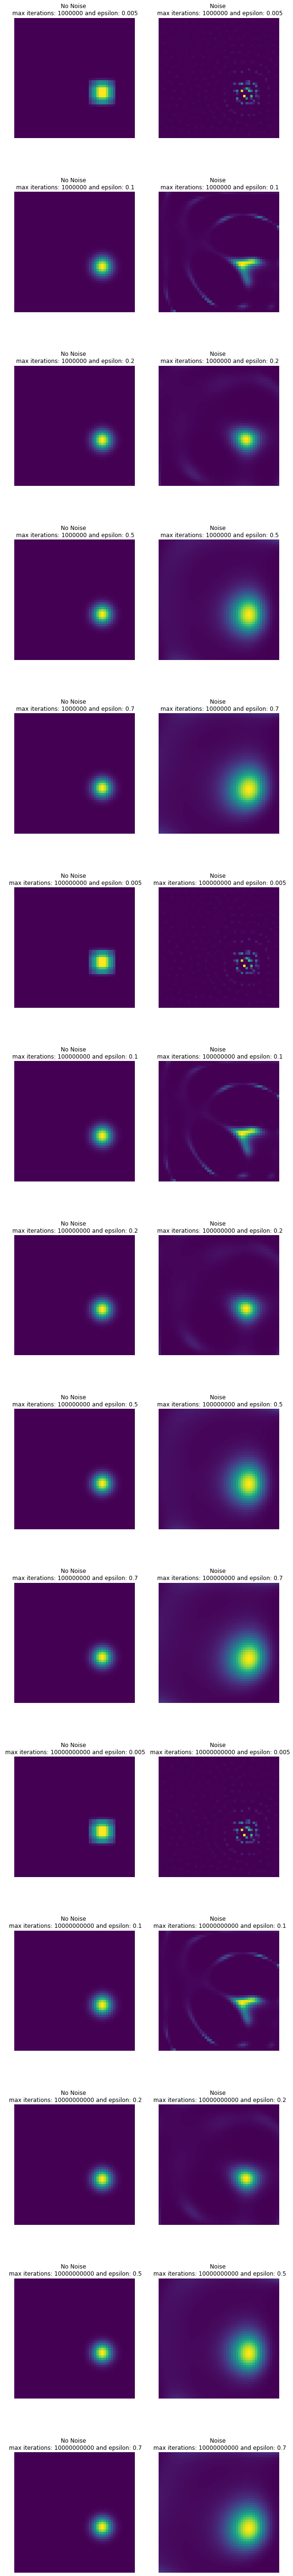

In [64]:
plot_compare(qyes, qno) 

In [86]:
img_index = np.empty((0,2), int)
for i in range (2):
    index = rng.choice(np.arange(199), size=(2), replace=False)
    #can add code here later in case img_index1 == img_index2
    img_index = np.append(img_index, np.array([index]), axis=0)
    
noise = abs(np.load("./artificial_data.npy")[img_index])
nonoise = abs(np.load("./artificial_data_no_noise.npy")[img_index])    

    
#print(img_index)

[[144 163]
 [ 57 160]]
[[[0.03151127 0.20044301 0.232481   ... 0.02283745 0.04130085 0.06911015]
  [0.208811   0.02774659 0.11849136 ... 0.05748739 0.10015589 0.12111757]
  [0.12883061 0.17848089 0.06867638 ... 0.0494407  0.11267886 0.21926115]
  ...
  [0.03754877 0.14570784 0.07746012 ... 0.07568827 0.0270006  0.25262966]
  [0.10568591 0.09115062 0.01750323 ... 0.01623273 0.03699364 0.07409376]
  [0.03703513 0.14802089 0.00890517 ... 0.20580485 0.07052683 0.08652849]]

 [[0.14932889 0.00935762 0.12272586 ... 0.01738137 0.16037852 0.00058607]
  [0.05263323 0.04556256 0.03489033 ... 0.01508272 0.05151733 0.15055432]
  [0.12625002 0.00350579 0.09579837 ... 0.00422806 0.17123625 0.2006576 ]
  ...
  [0.16838698 0.0150622  0.08834354 ... 0.04224601 0.1158052  0.0250689 ]
  [0.11050634 0.15420806 0.07209264 ... 0.07227791 0.01535008 0.12858096]
  [0.2091915  0.14770355 0.11616859 ... 0.14114036 0.08044589 0.01000977]]]


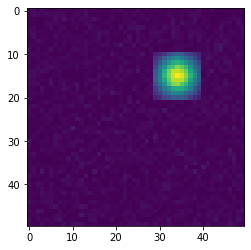

In [93]:
print(img_index)
print(noise[0])
plt.imshow(noise[1][0])


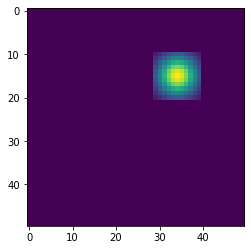

In [94]:
plt.imshow(nonoise[1][0])

In [49]:
os.chdir("/Users/bananasacks/Desktop/Optimal Transport Internship/Optimal_Transport/pascalle_s_drafts/Debiased_Sinkhorn_draft") 

In [69]:
import _main
from load_data import load_data
from time import time 
from computeK import computeK 

In [ ]:
#so I want to run the sinkhorn bary algo with each group of pairs